In [2]:
import gym
import numpy as np
env=gym.make('CartPole-v1')
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 2


In [8]:
import tensorflow as tf
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4,
                action_size=2, hidden_size=10,
                name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
    

In [4]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                              size=batch_size,
                              replace=False)
        return [self.buffer[ii] for ii in idx]

In [5]:
train_episodes=1000
max_steps=200          # max steps in an episode
gamma=0.99             # future reward discount

# Exploration parameters 
explore_start = 1.0    # exploration probability at start
explore_stop = 0.01    # minium exploration probability
decay_rate = 0.0001    # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64       # number of units in each Q-network hidden layer
learning_rate = 0.0001 # Q-network learning rate

# Memory parameters
memory_size = 10000    # memory capacity
batch_size = 20        # experience mini-batch size
pretrain_length = batch_size   # number experience to pretrain the memory


In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

In [12]:
env.reset()
state, reward, done, _ = env.step(env.action_space.sample())
memory=Memory(max_size=memory_size)

for ii in range(pretrain_length):
    action=env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state))
        
        env.reset()
        state, reward, done, _ =env.step(env.action_space.sample())
        
    else:
        memory.add((state, action, reward, next_state))
        state=next_state

# Training
Below we'll train our agent

In [40]:
# Now train with experience
saver = tf.train.Saver()
rewards_list=[]
with tf.Session() as sess:
    # Initialis variables
    sess.run(tf.global_variables_initializer())
    
    step=0
    for ep in range(1, train_episodes):
        total_reward=0
        t=0
        while t < max_steps:
            step += 1
            # env.render()
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
                
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action=np.argmax(Qs)
                
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                     'Total reward: {}'.format(total_reward),
                     'Training loss: {:.4f}'.format(loss),
                     'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
                
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0,0)
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole.ckpt")
                    
                

Episode: 1 Total reward: 7.0 Training loss: 1.0207 Explore P: 0.9993
Episode: 2 Total reward: 22.0 Training loss: 1.0051 Explore P: 0.9971
Episode: 3 Total reward: 20.0 Training loss: 0.9713 Explore P: 0.9952
Episode: 4 Total reward: 15.0 Training loss: 1.0480 Explore P: 0.9937
Episode: 5 Total reward: 13.0 Training loss: 1.0851 Explore P: 0.9924
Episode: 6 Total reward: 11.0 Training loss: 1.0213 Explore P: 0.9913
Episode: 7 Total reward: 17.0 Training loss: 1.0946 Explore P: 0.9897
Episode: 8 Total reward: 44.0 Training loss: 1.1282 Explore P: 0.9854
Episode: 9 Total reward: 13.0 Training loss: 1.2168 Explore P: 0.9841
Episode: 10 Total reward: 10.0 Training loss: 0.9323 Explore P: 0.9831
Episode: 11 Total reward: 14.0 Training loss: 1.0518 Explore P: 0.9818
Episode: 12 Total reward: 24.0 Training loss: 1.2527 Explore P: 0.9794
Episode: 13 Total reward: 16.0 Training loss: 1.2117 Explore P: 0.9779
Episode: 14 Total reward: 42.0 Training loss: 1.2789 Explore P: 0.9738
Episode: 15 Tota

Episode: 120 Total reward: 28.0 Training loss: 40.5690 Explore P: 0.7943
Episode: 121 Total reward: 13.0 Training loss: 186.7946 Explore P: 0.7933
Episode: 122 Total reward: 26.0 Training loss: 6.7090 Explore P: 0.7913
Episode: 123 Total reward: 12.0 Training loss: 180.5267 Explore P: 0.7903
Episode: 124 Total reward: 16.0 Training loss: 60.8304 Explore P: 0.7891
Episode: 125 Total reward: 34.0 Training loss: 107.4268 Explore P: 0.7864
Episode: 126 Total reward: 17.0 Training loss: 55.0789 Explore P: 0.7851
Episode: 127 Total reward: 22.0 Training loss: 151.0206 Explore P: 0.7834
Episode: 128 Total reward: 11.0 Training loss: 136.5974 Explore P: 0.7826
Episode: 129 Total reward: 15.0 Training loss: 56.3954 Explore P: 0.7814
Episode: 130 Total reward: 9.0 Training loss: 52.0259 Explore P: 0.7807
Episode: 131 Total reward: 32.0 Training loss: 8.0591 Explore P: 0.7782
Episode: 132 Total reward: 32.0 Training loss: 51.8315 Explore P: 0.7758
Episode: 133 Total reward: 15.0 Training loss: 11

Episode: 237 Total reward: 10.0 Training loss: 2.8011 Explore P: 0.6542
Episode: 238 Total reward: 22.0 Training loss: 130.4635 Explore P: 0.6528
Episode: 239 Total reward: 16.0 Training loss: 37.4345 Explore P: 0.6518
Episode: 240 Total reward: 11.0 Training loss: 121.4752 Explore P: 0.6510
Episode: 241 Total reward: 16.0 Training loss: 2.2762 Explore P: 0.6500
Episode: 242 Total reward: 11.0 Training loss: 0.8903 Explore P: 0.6493
Episode: 243 Total reward: 8.0 Training loss: 81.3777 Explore P: 0.6488
Episode: 244 Total reward: 10.0 Training loss: 1.1108 Explore P: 0.6482
Episode: 245 Total reward: 32.0 Training loss: 1.6018 Explore P: 0.6461
Episode: 246 Total reward: 26.0 Training loss: 2.2046 Explore P: 0.6445
Episode: 247 Total reward: 11.0 Training loss: 43.3272 Explore P: 0.6438
Episode: 248 Total reward: 15.0 Training loss: 68.7417 Explore P: 0.6428
Episode: 249 Total reward: 8.0 Training loss: 40.7396 Explore P: 0.6423
Episode: 250 Total reward: 11.0 Training loss: 38.5377 Ex

Episode: 351 Total reward: 28.0 Training loss: 0.6609 Explore P: 0.5413
Episode: 352 Total reward: 21.0 Training loss: 22.8450 Explore P: 0.5402
Episode: 353 Total reward: 43.0 Training loss: 1.2798 Explore P: 0.5380
Episode: 354 Total reward: 94.0 Training loss: 18.9145 Explore P: 0.5330
Episode: 355 Total reward: 76.0 Training loss: 9.9650 Explore P: 0.5291
Episode: 356 Total reward: 78.0 Training loss: 13.3695 Explore P: 0.5250
Episode: 357 Total reward: 27.0 Training loss: 22.4178 Explore P: 0.5236
Episode: 358 Total reward: 119.0 Training loss: 18.1231 Explore P: 0.5176
Episode: 359 Total reward: 89.0 Training loss: 7.8731 Explore P: 0.5131
Episode: 360 Total reward: 48.0 Training loss: 13.2868 Explore P: 0.5106
Episode: 361 Total reward: 75.0 Training loss: 1.3846 Explore P: 0.5069
Episode: 362 Total reward: 11.0 Training loss: 8.8579 Explore P: 0.5064
Episode: 363 Total reward: 33.0 Training loss: 1.0953 Explore P: 0.5047
Episode: 364 Total reward: 20.0 Training loss: 0.9209 Exp

Episode: 466 Total reward: 70.0 Training loss: 1.3452 Explore P: 0.3493
Episode: 467 Total reward: 37.0 Training loss: 2.4824 Explore P: 0.3480
Episode: 468 Total reward: 48.0 Training loss: 1.8922 Explore P: 0.3464
Episode: 469 Total reward: 52.0 Training loss: 64.4627 Explore P: 0.3447
Episode: 470 Total reward: 104.0 Training loss: 1.8227 Explore P: 0.3412
Episode: 471 Total reward: 90.0 Training loss: 1.8385 Explore P: 0.3382
Episode: 472 Total reward: 64.0 Training loss: 99.6567 Explore P: 0.3361
Episode: 473 Total reward: 33.0 Training loss: 1.6393 Explore P: 0.3351
Episode: 474 Total reward: 112.0 Training loss: 64.8122 Explore P: 0.3314
Episode: 475 Total reward: 126.0 Training loss: 16.3375 Explore P: 0.3274
Episode: 476 Total reward: 35.0 Training loss: 33.0808 Explore P: 0.3263
Episode: 477 Total reward: 59.0 Training loss: 34.5856 Explore P: 0.3244
Episode: 478 Total reward: 84.0 Training loss: 0.9890 Explore P: 0.3218
Episode: 479 Total reward: 63.0 Training loss: 31.4297 

Episode: 580 Total reward: 81.0 Training loss: 52.2595 Explore P: 0.1847
Episode: 581 Total reward: 32.0 Training loss: 2.0174 Explore P: 0.1841
Episode: 582 Total reward: 34.0 Training loss: 2.1519 Explore P: 0.1836
Episode: 583 Total reward: 40.0 Training loss: 1.7964 Explore P: 0.1829
Episode: 584 Total reward: 42.0 Training loss: 1.7070 Explore P: 0.1821
Episode: 585 Total reward: 25.0 Training loss: 1.9929 Explore P: 0.1817
Episode: 586 Total reward: 41.0 Training loss: 2.2972 Explore P: 0.1810
Episode: 587 Total reward: 74.0 Training loss: 2.5211 Explore P: 0.1797
Episode: 588 Total reward: 59.0 Training loss: 2.7260 Explore P: 0.1787
Episode: 589 Total reward: 72.0 Training loss: 48.0787 Explore P: 0.1775
Episode: 590 Total reward: 62.0 Training loss: 2.0982 Explore P: 0.1765
Episode: 591 Total reward: 80.0 Training loss: 1.9972 Explore P: 0.1752
Episode: 592 Total reward: 76.0 Training loss: 1.2337 Explore P: 0.1739
Episode: 593 Total reward: 78.0 Training loss: 2.5292 Explore 

Episode: 710 Total reward: 184.0 Training loss: 0.3287 Explore P: 0.0479
Episode: 711 Total reward: 76.0 Training loss: 0.3745 Explore P: 0.0476
Episode: 713 Total reward: 32.0 Training loss: 51.2836 Explore P: 0.0467
Episode: 714 Total reward: 61.0 Training loss: 0.3740 Explore P: 0.0465
Episode: 715 Total reward: 66.0 Training loss: 0.4484 Explore P: 0.0463
Episode: 716 Total reward: 65.0 Training loss: 0.1247 Explore P: 0.0460
Episode: 717 Total reward: 103.0 Training loss: 0.2651 Explore P: 0.0456
Episode: 718 Total reward: 67.0 Training loss: 51.2947 Explore P: 0.0454
Episode: 719 Total reward: 58.0 Training loss: 0.5824 Explore P: 0.0452
Episode: 720 Total reward: 101.0 Training loss: 0.2423 Explore P: 0.0449
Episode: 721 Total reward: 80.0 Training loss: 0.2545 Explore P: 0.0446
Episode: 722 Total reward: 79.0 Training loss: 0.5249 Explore P: 0.0443
Episode: 723 Total reward: 107.0 Training loss: 0.4609 Explore P: 0.0439
Episode: 724 Total reward: 80.0 Training loss: 0.2278 Expl

Episode: 834 Total reward: 140.0 Training loss: 14.1120 Explore P: 0.0220
Episode: 837 Total reward: 99.0 Training loss: 0.1902 Explore P: 0.0214
Episode: 840 Total reward: 99.0 Training loss: 0.1394 Explore P: 0.0209
Episode: 843 Total reward: 99.0 Training loss: 0.2826 Explore P: 0.0203
Episode: 846 Total reward: 99.0 Training loss: 0.2298 Explore P: 0.0198
Episode: 849 Total reward: 99.0 Training loss: 0.2725 Explore P: 0.0194
Episode: 852 Total reward: 99.0 Training loss: 5.2827 Explore P: 0.0189
Episode: 855 Total reward: 99.0 Training loss: 3.4041 Explore P: 0.0185
Episode: 858 Total reward: 99.0 Training loss: 0.2110 Explore P: 0.0181
Episode: 861 Total reward: 99.0 Training loss: 0.5882 Explore P: 0.0177
Episode: 864 Total reward: 99.0 Training loss: 0.1573 Explore P: 0.0173
Episode: 867 Total reward: 99.0 Training loss: 0.1347 Explore P: 0.0169
Episode: 870 Total reward: 99.0 Training loss: 0.3286 Explore P: 0.0166
Episode: 873 Total reward: 99.0 Training loss: 0.0748 Explore 

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/N


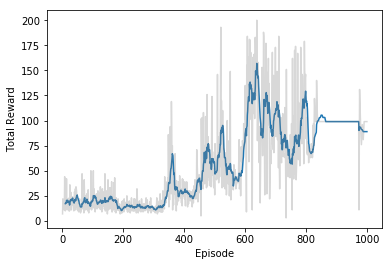

In [43]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')np.random.rand()
plt.ylabel('Total Reward')
